In [7]:
import sys
import os
import time
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler


print('NOVA_HOME is at', os.getenv('NOVA_HOME'))
sys.path.insert(1, os.getenv('NOVA_HOME'))
%load_ext autoreload
%autoreload 2

from src.common.utils import load_config_file
from src.embeddings.embeddings_utils import load_embeddings
from src.analysis.analyzer_multiplex_markers import AnalyzerMultiplexMarkers

NOVA_HOME is at /home/projects/hornsteinlab/Collaboration/NOVA_GAL/NOVA
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def count_labels(y):
    counts = Counter(y)
    for label, count in counts.items():
        print(f"{label}: {count}")
        
def plot_confusion_matrix(y_true, y_pred, label_encoder, shorten_labels=True, rotation=45):
    """
    Plots a confusion matrix with correctly aligned labels and optional label cleaning.
    
    Parameters:
        y_true (array-like): True labels (encoded).
        y_pred (array-like): Predicted labels (encoded).
        label_encoder (LabelEncoder): Fitted LabelEncoder instance.
        shorten_labels (bool): Whether to remove '_Untreated' suffix.
        rotation (int): Rotation angle for x-axis labels.
    """
    # Define label order
    label_order = label_encoder.transform(label_encoder.classes_)
    labels = label_encoder.classes_

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=label_order)

    # Clean labels if requested
    if shorten_labels:
        display_labels = [l.replace('_Untreated', '') for l in labels]
    else:
        display_labels = labels

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(xticks_rotation=rotation)
    plt.tight_layout()
    plt.show()

### Load embeddings and labels

In [3]:
batch = 10  # You can change this value as needed
pickle_path = f"data/newNeuronsD8FigureConfig_UMAP2_B{batch}.pkl"

# Load the pickle file
with open(pickle_path, "rb") as f:
    data = pickle.load(f)

# Extract embeddings and labels
embeddings = data.get("embeddings")
labels = data.get("labels")
print(np.shape(labels), np.shape(embeddings), np.unique(labels), len(np.unique(labels)))
count_labels(labels)

(7276,) (7276, 5568) ['FUSHeterozygous_Untreated' 'FUSHomozygous_Untreated'
 'FUSRevertant_Untreated' 'OPTN_Untreated' 'TBK1_Untreated'
 'TDP43_Untreated' 'WT_Untreated'] 7
FUSHeterozygous_Untreated: 267
FUSHomozygous_Untreated: 666
FUSRevertant_Untreated: 45
OPTN_Untreated: 1763
TBK1_Untreated: 188
TDP43_Untreated: 2151
WT_Untreated: 2196


In [4]:
## 3 balance oversample, no norm

y = labels
X = embeddings

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)
count_labels(y_train)

balance = True
if balance: # Balance
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)

norm = True
if norm: # Normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

print('fit')
clf = LogisticRegression(max_iter=300, solver='saga', verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)
print('predict')
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))    

6: 1756
3: 1410
5: 1721
1: 533
4: 150
0: 214
2: 36
fit


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.16285367
Epoch 3, change: 0.08251443
Epoch 4, change: 0.06661603
Epoch 5, change: 0.04529908
Epoch 6, change: 0.04247771
Epoch 7, change: 0.03191662
Epoch 8, change: 0.02168440
Epoch 9, change: 0.02069129
Epoch 10, change: 0.01851347
Epoch 11, change: 0.01960657
Epoch 12, change: 0.01585145
Epoch 13, change: 0.01418467
Epoch 14, change: 0.01365701
Epoch 15, change: 0.01244653
Epoch 16, change: 0.01162096
Epoch 17, change: 0.01084116
Epoch 18, change: 0.01047341
Epoch 19, change: 0.00978860
Epoch 20, change: 0.00941623
Epoch 21, change: 0.00866982
Epoch 22, change: 0.00856581
Epoch 23, change: 0.00798684
Epoch 24, change: 0.00747329
Epoch 25, change: 0.00723844
Epoch 26, change: 0.00656736
Epoch 27, change: 0.00665002
Epoch 28, change: 0.00647962
Epoch 29, change: 0.00652402
Epoch 30, change: 0.00650754
Epoch 31, change: 0.00549902
Epoch 32, change: 0.00545719
Epoch 33, change: 0.00549024
Epoch 34, change: 0.00533057
Epoch 35, change: 0.005

/home/projects/hornsteinlab/galavir/.conda/envs/nova/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 32.2min finished


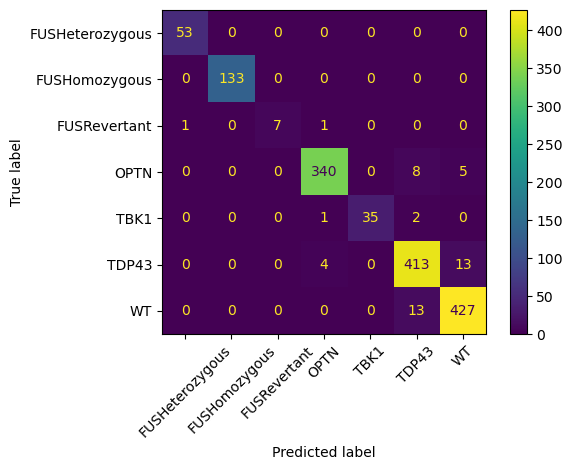

In [8]:
plot_confusion_matrix(y_test, y_pred, le)

In [ ]:
# ##2 no norm bal in classifier
# clf = LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced')
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred, target_names=le.classes_))    

In [14]:
##1 no norm no bal
clf = LogisticRegression(max_iter=1000, solver='saga')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                           precision    recall  f1-score   support

FUSHeterozygous_Untreated       0.98      1.00      0.99        53
  FUSHomozygous_Untreated       1.00      1.00      1.00       133
   FUSRevertant_Untreated       1.00      0.33      0.50         9
           OPTN_Untreated       0.97      0.98      0.97       353
           TBK1_Untreated       1.00      0.82      0.90        38
          TDP43_Untreated       0.95      0.97      0.96       430
             WT_Untreated       0.98      0.98      0.98       440

                 accuracy                           0.97      1456
                macro avg       0.98      0.87      0.90      1456
             weighted avg       0.97      0.97      0.97      1456



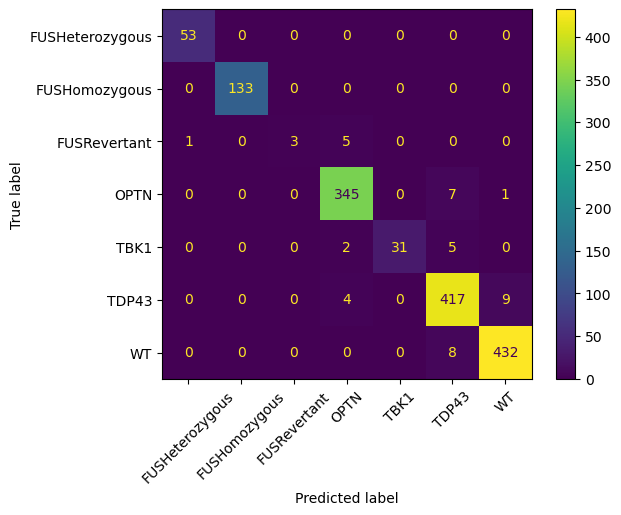

In [21]:
# Get label order from LabelEncoder
label_order = le.transform(le.classes_)  # e.g. [0, 1, 2, 3, 4, 5, 6]
labels = le.classes_

# Compute confusion matrix with fixed label order
cm = confusion_matrix(y_test, y_pred, labels=label_order)

# Optional: shorten labels
clean_labels = [l.replace("_Untreated", "") for l in labels]

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clean_labels)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))